In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import lil_matrix
import gurobipy as gp
from gurobipy import GRB
from collections import defaultdict

def a():
    # Sigma value for similarity calculation
    sigma = 0.03  # Adjust as needed based on the image characteristics


    # Load the image using PIL
    image_path = 'swan.jpg'
    image = Image.open(image_path)
    # Convert the image to grayscale
    image = image.convert('L')  # 'L' mode converts the image to grayscale (8-bit pixels, black and white)
    # Convert the image to a numpy array
    pixel_matrix = np.array(image, dtype=np.float64) / 255.0  # Normalize pixel values to range [0, 1]
    # Visualize the image
    plt.imshow(pixel_matrix, cmap='gray', interpolation='none')
    plt.colorbar(label='Intensity')
    plt.title('Grayscale Image')
    plt.axis('off')
    plt.show()


    # Get image dimensions
    num_rows, num_cols = pixel_matrix.shape
    num_pixels = num_rows * num_cols


    # Flatten the pixel matrix and compute intensity histogram
    pixel_values = pixel_matrix.flatten()
    # Define thresholds based on percentiles
    lower_percentile = np.percentile(pixel_values, 5)   # Background threshold
    upper_percentile = np.percentile(pixel_values, 90)  # Foreground threshold
    # Identify background and foreground seed pixels
    background_seed_pixels = np.argwhere(pixel_matrix <= lower_percentile)
    foreground_seed_pixels = np.argwhere(pixel_matrix >= upper_percentile)
    print(background_seed_pixels)
    print(foreground_seed_pixels)

    # Helper function to map 2D pixel positions to 1D node index
    def pixel_to_node(row, col):
        return row * num_cols + col


    # Map these pixels to node indices
    background_nodes = [pixel_to_node(row, col) for row, col in background_seed_pixels]
    foreground_nodes = [pixel_to_node(row, col) for row, col in foreground_seed_pixels]
    print(background_nodes)
    print(foreground_nodes)

    # background_nodes = pixel_to_node(48, 65)
    # foreground_nodes = pixel_to_node(51, 82)
    # print(background_nodes)
    # print(foreground_nodes)
                        

    # Initialize the adjacency matrix using a sparse representation
    network_with_similarity = lil_matrix((num_pixels + 2, num_pixels + 2))  # +2 for source and sink
    # Function to calculate the similarity between two pixel intensities
    def calculate_similarity(Ii, Ij, sigma):
        diff = Ii - Ij
        similarity = 100 * np.exp(- (diff**2) / (2 * sigma**2))
        return int(np.ceil(similarity))
    # Build the network
    for row in range(num_rows):
        for col in range(num_cols):
            node = pixel_to_node(row, col)
            Ii = pixel_matrix[row, col]
            # Neighbor positions (up, down, left, right)
            neighbors = []
            if row > 0:  # Up
                neighbors.append((row - 1, col))
            if row < num_rows - 1:  # Down
                neighbors.append((row + 1, col))
            if col > 0:  # Left
                neighbors.append((row, col - 1))
            if col < num_cols - 1:  # Right
                neighbors.append((row, col + 1))
            for n_row, n_col in neighbors:
                neighbor_node = pixel_to_node(n_row, n_col)
                Ij = pixel_matrix[n_row, n_col]
                similarity = calculate_similarity(Ii, Ij, sigma)
                network_with_similarity[node, neighbor_node] = similarity
                network_with_similarity[neighbor_node, node] = similarity  # Undirected edge
    # Define source and sink node indices
    source_node = num_pixels     # Index of source node
    sink_node = num_pixels + 1   # Index of sink node
    # Convert network to CSR format for efficient assignment
    network_csr = network_with_similarity.tocsr()
    max_similarity = network_csr.max()

    # Connect source to background nodes
    for node in background_nodes:
        network_csr[source_node, node] = max_similarity
        network_csr[node, source_node] = 0  # Flow only from source to background nodes
    # Connect foreground nodes to sink
    for node in foreground_nodes:
        network_csr[node, sink_node] = max_similarity
        network_csr[sink_node, node] = 0  # Flow only from foreground nodes to sink

    # Update network_with_similarity with the new connections
    network_with_similarity = network_csr.tolil()
    # Create Gurobi model
    model = gp.Model()
    # Extract the list of edges with non-zero capacities
    network_coo = network_with_similarity.tocoo()
    rows = network_coo.row
    cols = network_coo.col
    capacities = network_coo.data  # This is already a 1D numpy array
    # Create a dictionary of edges with capacities
    edges = {}
    for i in range(len(rows)):
        from_node = rows[i]
        to_node = cols[i]
        capacity = capacities[i]
        if capacity > 0:
            edges[(from_node, to_node)] = capacity
    # Create flow variables for each edge
    flow_vars = model.addVars(edges.keys(), lb=0, ub=edges, name="flow")
    # Set the objective to maximize the total flow from source to sink
    inflow_to_sink = gp.quicksum(flow_vars[i, sink_node] for i in network_with_similarity[:, sink_node].nonzero()[0])
    model.setObjective(inflow_to_sink, GRB.MAXIMIZE)
    # Add flow conservation constraints for all nodes except source and sink
    nodes = set(range(num_pixels))
    # Note: We exclude source_node and sink_node from flow conservation constraints
    incoming_edges = defaultdict(list)
    outgoing_edges = defaultdict(list)
    for (i, j) in edges.keys():
        outgoing_edges[i].append((i, j))
        incoming_edges[j].append((i, j))
    for node in nodes:
        inflow = gp.quicksum(flow_vars[edge] for edge in incoming_edges[node])
        outflow = gp.quicksum(flow_vars[edge] for edge in outgoing_edges[node])
        model.addConstr(inflow == outflow, name=f"flow_conservation_{node}")
    model.Params.OutputFlag = 0
    # Optimize the model
    model.optimize()
    # Get the optimized flows
    flow_values = model.getAttr('X', flow_vars)
    # Build the residual network
    residual_edges = defaultdict(list)
    for (i, j), capacity in edges.items():
        flow = flow_values[(i, j)]
        # Residual capacity in the forward direction
        residual_capacity = capacity - flow
        if residual_capacity > 1e-6:
            residual_edges[i].append((j, residual_capacity))
        # Residual capacity in the reverse direction
        if flow > 1e-6:
            residual_edges[j].append((i, flow))
    # Perform depth-first search from the source node
    def dfs(residual_edges, source_node):
        visited = set()
        stack = [source_node]
        while stack:
            node = stack.pop()
            if node not in visited:
                visited.add(node)
                for neighbor, capacity in residual_edges.get(node, []):
                    if capacity > 1e-6 and neighbor not in visited:
                        stack.append(neighbor)
        return visited
    reachable_nodes = dfs(residual_edges, source_node)
    # Find the cuts
    cuts = []
    cut_capacity = 0
    for (i, j), capacity in edges.items():
        if i in reachable_nodes and j not in reachable_nodes:
            cuts.append((i, j))
            cut_capacity += capacity
    print(f"Maximum flow value: {model.ObjVal}")
    print(f"Total cut capacity: {cut_capacity}")
    count = 0
    for cut in cuts:
        count += 1
    print(count)
    # Plot the original grayscale image with cuts highlighted in red
    plt.imshow(pixel_matrix, cmap='gray', interpolation='none')
    plt.title('Grayscale Image with Cuts Highlighted')
    plt.colorbar()
    # Highlight the cuts in red on top of the grayscale image
    for i, j in cuts:
        # Convert the node indices back to 2D coordinates
        if i < num_pixels and j < num_pixels:  # Ensure it's a pixel-to-pixel cut
            row_i, col_i = divmod(i, num_cols)
            row_j, col_j = divmod(j, num_cols)
            # Plot a red line between the cut pixels
            plt.plot([col_i, col_j], [row_i, row_j], color='red', linewidth=1)
    # Turn off the axis
    plt.axis('off')
    # Show the final plot
    plt.show()




In [2]:
# a()

In [3]:
def b(sig):


    # Sigma value for similarity calculation
    sigma = sig  # Adjust as needed based on the image characteristics

    # Load the image using PIL
    image_path = 'swan.jpg'
    image = Image.open(image_path)

    # Convert the image to grayscale
    image = image.convert('L')  # 'L' mode converts the image to grayscale (8-bit pixels, black and white)

    # Convert the image to a numpy array and normalize pixel values to range [0, 1]
    pixel_matrix = np.array(image, dtype=np.float64) / 255.0  

    # Visualize the image
    plt.imshow(pixel_matrix, cmap='gray', interpolation='none')
    plt.colorbar(label='Intensity')
    plt.title('Grayscale Image')
    plt.axis('off')
    plt.show()

    # Get image dimensions
    num_rows, num_cols = pixel_matrix.shape
    num_pixels = num_rows * num_cols

    # Find the minimum and maximum intensity pixels (background and foreground)
    min_intensity = np.min(pixel_matrix)
    max_intensity = np.max(pixel_matrix)

    # Get the row, col for minimum and maximum intensity
    background_seed_pixel = np.argwhere(pixel_matrix == min_intensity)[0]
    foreground_seed_pixel = np.argwhere(pixel_matrix == max_intensity)[0]

    print(f"Background pixel at {background_seed_pixel} with intensity {min_intensity}")
    print(f"Foreground pixel at {foreground_seed_pixel} with intensity {max_intensity}")

    # Helper function to map 2D pixel positions to 1D node index
    def pixel_to_node(row, col):
        return row * num_cols + col

    # Map the background and foreground seed pixels to node indices
    background_node = pixel_to_node(*background_seed_pixel)
    foreground_node = pixel_to_node(*foreground_seed_pixel)

    print(f"Background node: {background_node}")
    print(f"Foreground node: {foreground_node}")

    # Initialize the adjacency matrix using a sparse representation
    network_with_similarity = lil_matrix((num_pixels + 2, num_pixels + 2))  # +2 for source and sink

    # Function to calculate the similarity between two pixel intensities
    def calculate_similarity(Ii, Ij, sigma):
        diff = Ii - Ij
        similarity = 100 * np.exp(- (diff**2) / (2 * sigma**2))
        return int(np.ceil(similarity))

    # Build the network with pixel similarities
    for row in range(num_rows):
        for col in range(num_cols):
            node = pixel_to_node(row, col)
            Ii = pixel_matrix[row, col]
            # Neighbor positions (up, down, left, right)
            neighbors = []
            if row > 0:  # Up
                neighbors.append((row - 1, col))
            if row < num_rows - 1:  # Down
                neighbors.append((row + 1, col))
            if col > 0:  # Left
                neighbors.append((row, col - 1))
            if col < num_cols - 1:  # Right
                neighbors.append((row, col + 1))
            for n_row, n_col in neighbors:
                neighbor_node = pixel_to_node(n_row, n_col)
                Ij = pixel_matrix[n_row, n_col]
                similarity = calculate_similarity(Ii, Ij, sigma)
                network_with_similarity[node, neighbor_node] = similarity
                network_with_similarity[neighbor_node, node] = similarity  # Undirected edge

    # Define source and sink node indices
    source_node = num_pixels     # Index of source node
    sink_node = num_pixels + 1   # Index of sink node

    # Convert network to CSR format for efficient assignment
    network_csr = network_with_similarity.tocsr()
    max_similarity = network_csr.max()

    # Connect source to the background node
    network_csr[source_node, background_node] = max_similarity
    network_csr[background_node, source_node] = 0  # Flow only from source to background node

    # Connect foreground node to sink
    network_csr[foreground_node, sink_node] = max_similarity
    network_csr[sink_node, foreground_node] = 0  # Flow only from foreground node to sink

    # Convert the network back to lil format
    network_with_similarity = network_csr.tolil()

    # Create Gurobi model
    model = gp.Model()

    # Extract the list of edges with non-zero capacities
    network_coo = network_with_similarity.tocoo()
    rows = network_coo.row
    cols = network_coo.col
    capacities = network_coo.data  # This is already a 1D numpy array

    # Create a dictionary of edges with capacities
    edges = {}
    for i in range(len(rows)):
        from_node = rows[i]
        to_node = cols[i]
        capacity = capacities[i]
        if capacity > 0:
            edges[(from_node, to_node)] = capacity

    # Create flow variables for each edge
    flow_vars = model.addVars(edges.keys(), lb=0, ub=edges, name="flow")

    # Set the objective to maximize the total flow from source to sink
    inflow_to_sink = gp.quicksum(flow_vars[i, sink_node] for i in network_with_similarity[:, sink_node].nonzero()[0])
    model.setObjective(inflow_to_sink, GRB.MAXIMIZE)

    # Add flow conservation constraints for all nodes except source and sink
    nodes = set(range(num_pixels))

    # Note: We exclude source_node and sink_node from flow conservation constraints
    incoming_edges = defaultdict(list)
    outgoing_edges = defaultdict(list)
    for (i, j) in edges.keys():
        outgoing_edges[i].append((i, j))
        incoming_edges[j].append((i, j))

    for node in nodes:
        inflow = gp.quicksum(flow_vars[edge] for edge in incoming_edges[node])
        outflow = gp.quicksum(flow_vars[edge] for edge in outgoing_edges[node])
        model.addConstr(inflow == outflow, name=f"flow_conservation_{node}")

    model.Params.OutputFlag = 0
    # Optimize the model
    model.optimize()

    # Get the optimized flows
    flow_values = model.getAttr('X', flow_vars)

    # Build the residual network
    residual_edges = defaultdict(list)
    for (i, j), capacity in edges.items():
        flow = flow_values[(i, j)]
        # Residual capacity in the forward direction
        residual_capacity = capacity - flow
        if residual_capacity > 1e-6:
            residual_edges[i].append((j, residual_capacity))
        # Residual capacity in the reverse direction
        if flow > 1e-6:
            residual_edges[j].append((i, flow))

    # Perform depth-first search from the source node
    def dfs(residual_edges, source_node):
        visited = set()
        stack = [source_node]
        while stack:
            node = stack.pop()
            if node not in visited:
                visited.add(node)
                for neighbor, capacity in residual_edges.get(node, []):
                    if capacity > 1e-6 and neighbor not in visited:
                        stack.append(neighbor)
        return visited

    reachable_nodes = dfs(residual_edges, source_node)

    # Find the cuts
    cuts = []
    cut_capacity = 0
    for (i, j), capacity in edges.items():
        if i in reachable_nodes and j not in reachable_nodes:
            cuts.append((i, j))
            cut_capacity += capacity

    print(f"Maximum flow value: {model.ObjVal}")
    print(f"Total cut capacity: {cut_capacity}")
    print(f"Number of cuts: {len(cuts)}")

    # Plot the original grayscale image with cuts highlighted in red
    plt.imshow(pixel_matrix, cmap='gray', interpolation='none')
    plt.title('Grayscale Image with Cuts Highlighted')
    plt.colorbar()

    # Highlight the cuts in red on top of the grayscale image
    for i, j in cuts:
        # Convert the node indices back to 2D coordinates
        if i < num_pixels and j < num_pixels:  # Ensure it's a pixel-to-pixel cut
            row_i, col_i = divmod(i, num_cols)
            row_j, col_j = divmod(j, num_cols)
            # Plot a red line between the cut pixels
            plt.plot([col_i, col_j], [row_i, row_j], color='red', linewidth=1)

    # Turn off the axis
    plt.axis('off')
    # Show the final plot
    plt.show()


In [4]:
# for i in np.arange(0.01, 1, 0.01):
#     b(i)

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
import gurobipy as gp
from gurobipy import GRB
from collections import defaultdict


def run_image_segmentation():
    # Sigma value for similarity calculation
    sigma = 0.03  # Adjust as needed based on the image characteristics

    # Load the image using PIL
    image_path = 'swan.jpg'
    image = Image.open(image_path)

    # Convert the image to grayscale
    image = image.convert('L')  # 'L' mode converts the image to grayscale (8-bit pixels, black and white)

    # Convert the image to a numpy array
    pixel_matrix = np.array(image, dtype=np.float64) / 255.0  # Normalize pixel values to range [0, 1]

    # Visualize the image
    plt.imshow(pixel_matrix, cmap='gray', interpolation='none')
    plt.colorbar(label='Intensity')
    plt.title('Grayscale Image')
    plt.axis('off')
    plt.show()

    # Get image dimensions
    num_rows, num_cols = pixel_matrix.shape
    num_pixels = num_rows * num_cols

    # Helper function to map 2D pixel positions to 1D node index
    def pixel_to_node(row, col):
        return row * num_cols + col

    # Function to get manual input for background and foreground pixel coordinates
    def get_coordinates(prompt):
        print(prompt)
        x = int(input("Enter row (x) coordinate: "))
        y = int(input("Enter column (y) coordinate: "))
        return (x, y)

    # # Manually select background and foreground pixel coordinates
    # bg_x, bg_y = get_coordinates("Enter the background pixel coordinates:")
    # fg_x, fg_y = get_coordinates("Enter the foreground pixel coordinates:")

    bg_x, bg_y = 48, 65
    fg_x, fg_y = 51, 82

    # Map the selected pixel coordinates to nodes
    background_node = pixel_to_node(bg_x, bg_y)
    foreground_node = pixel_to_node(fg_x, fg_y)

    # Print the selected nodes for background and foreground
    print(f"Selected background node: {background_node} (coordinates: ({bg_x}, {bg_y}))")
    print(f"Selected foreground node: {foreground_node} (coordinates: ({fg_x}, {fg_y}))")

    # Define background and foreground nodes
    background_nodes = [background_node]
    foreground_nodes = [foreground_node]

    # Initialize the adjacency matrix using a sparse representation
    network_with_similarity = lil_matrix((num_pixels + 2, num_pixels + 2))  # +2 for source and sink

    # Function to calculate the similarity between two pixel intensities
    def calculate_similarity(Ii, Ij, sigma):
        diff = Ii - Ij
        similarity = 100 * np.exp(- (diff **2) / (2 * sigma**2))
        return int(np.ceil(similarity))

    # Build the network
    for row in range(num_rows):
        for col in range(num_cols):
            node = pixel_to_node(row, col)
            Ii = pixel_matrix[row, col]
            # Neighbor positions (up, down, left, right)
            neighbors = []
            if row > 0:  # Up
                neighbors.append((row - 1, col))
            if row < num_rows - 1:  # Down
                neighbors.append((row + 1, col))
            if col > 0:  # Left
                neighbors.append((row, col - 1))
            if col < num_cols - 1:  # Right
                neighbors.append((row, col + 1))

            for n_row, n_col in neighbors:
                neighbor_node = pixel_to_node(n_row, n_col)
                Ij = pixel_matrix[n_row, n_col]
                similarity = calculate_similarity(Ii, Ij, sigma)
                network_with_similarity[node, neighbor_node] = similarity
                network_with_similarity[neighbor_node, node] = similarity  # Undirected edge

    # Define source and sink node indices
    source_node = num_pixels  # Index of source node
    sink_node = num_pixels + 1  # Index of sink node

    # Convert network to CSR format for efficient assignment
    network_csr = network_with_similarity.tocsr()
    max_similarity = network_csr.max()

    # Connect source to background nodes
    for node in background_nodes:
        network_csr[source_node, node] = max_similarity
        network_csr[node, source_node] = 0  # Flow only from source to background nodes

    # Connect foreground nodes to sink
    for node in foreground_nodes:
        network_csr[node, sink_node] = max_similarity
        network_csr[sink_node, node] = 0  # Flow only from foreground nodes to sink

    # Update network_with_similarity with the new connections
    network_with_similarity = network_csr.tolil()

    # Create Gurobi model
    model = gp.Model()

    # Extract the list of edges with non-zero capacities
    network_coo = network_with_similarity.tocoo()
    rows = network_coo.row
    cols = network_coo.col
    capacities = network_coo.data  # This is already a 1D numpy array

    # Create a dictionary of edges with capacities
    edges = {}
    for i in range(len(rows)):
        from_node = rows[i]
        to_node = cols[i]
        capacity = capacities[i]
        if capacity > 0:
            edges[(from_node, to_node)] = capacity

    # Create flow variables for each edge
    flow_vars = model.addVars(edges.keys(), lb=0, ub=edges, name="flow")

    # Set the objective to maximize the total flow from source to sink
    inflow_to_sink = gp.quicksum(flow_vars[i, sink_node] for i in network_with_similarity[:, sink_node].nonzero()[0])
    model.setObjective(inflow_to_sink, GRB.MAXIMIZE)

    # Add flow conservation constraints for all nodes except source and sink
    nodes = set(range(num_pixels))
    incoming_edges = defaultdict(list)
    outgoing_edges = defaultdict(list)
    for (i, j) in edges.keys():
        outgoing_edges[i].append((i, j))
        incoming_edges[j].append((i, j))

    for node in nodes:
        inflow = gp.quicksum(flow_vars[edge] for edge in incoming_edges[node])
        outflow = gp.quicksum(flow_vars[edge] for edge in outgoing_edges[node])
        model.addConstr(inflow == outflow, name=f"flow_conservation_{node}")

    # Optimize the model
    model.Params.OutputFlag = 0
    model.optimize()

    # Get the optimized flows
    flow_values = model.getAttr('X', flow_vars)

    # Build the residual network
    residual_edges = defaultdict(list)
    for (i, j), capacity in edges.items():
        flow = flow_values[(i, j)]
        # Residual capacity in the forward direction
        residual_capacity = capacity - flow
        if residual_capacity > 1e-6:
            residual_edges[i].append((j, residual_capacity))
        # Residual capacity in the reverse direction
        if flow > 1e-6:
            residual_edges[j].append((i, flow))

    # Perform depth-first search from the source node
    def dfs(residual_edges, source_node):
        visited = set()
        stack = [source_node]
        while stack:
            node = stack.pop()
            if node not in visited:
                visited.add(node)
                for neighbor, capacity in residual_edges.get(node, []):
                    if capacity > 1e-6 and neighbor not in visited:
                        stack.append(neighbor)
        return visited

    reachable_nodes = dfs(residual_edges, source_node)

    # Find the cuts
    cuts = []
    cut_capacity = 0
    for (i, j), capacity in edges.items():
        if i in reachable_nodes and j not in reachable_nodes:
            cuts.append((i, j))
            cut_capacity += capacity

    print(f"Maximum flow value: {model.ObjVal}")
    print(f"Total cut capacity: {cut_capacity}")

    # Plot the original grayscale image with cuts highlighted in red
    plt.imshow(pixel_matrix, cmap='gray', interpolation='none')
    plt.title('Grayscale Image with Cuts Highlighted')
    plt.colorbar()

    # Highlight the cuts in red on top of the grayscale image
    for i, j in cuts:
        # Convert the node indices back to 2D coordinates
        if i < num_pixels and j < num_pixels:  # Ensure it's a pixel-to-pixel cut
            row_i, col_i = divmod(i, num_cols)
            row_j, col_j = divmod(j, num_cols)
            # Plot a red line between the cut pixels
            plt.plot([col_i, col_j], [row_i, row_j], color='red', linewidth=1)

    # Turn off the axis
    plt.axis('off')

    # Show the final plot
    plt.show()


# Run the image segmentation process
# run_image_segmentation()


In [8]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import lil_matrix
import gurobipy as gp
from gurobipy import GRB
from collections import defaultdict

def c():
    # Sigma value for similarity calculation
    sigma = 0.03  # Adjust as needed based on the image characteristics
    # Load the image using PIL
    image_path = 'bird2_down.jpg'
    image = Image.open(image_path)
    # Convert the image to grayscale
    image = image.convert('L')  # 'L' mode converts the image to grayscale (8-bit pixels, black and white)
    # Convert the image to a numpy array
    pixel_matrix = np.array(image, dtype=np.float64) / 255.0  # Normalize pixel values to range [0, 1]
    # Visualize the image
    plt.imshow(pixel_matrix, cmap='gray', interpolation='none')
    plt.colorbar(label='Intensity')
    plt.title('Grayscale Image')
    plt.axis('off')
    plt.show()
    # Get image dimensions
    num_rows, num_cols = pixel_matrix.shape
    num_pixels = num_rows * num_cols
    # Flatten the pixel matrix and compute intensity histogram
    pixel_values = pixel_matrix.flatten()
    # Define thresholds based on percentiles
    lower_percentile = np.percentile(pixel_values, 5)   # Background threshold
    upper_percentile = np.percentile(pixel_values, 90)  # Foreground threshold
    # Identify background and foreground seed pixels
    background_seed_pixels = np.argwhere(pixel_matrix <= lower_percentile)
    foreground_seed_pixels = np.argwhere(pixel_matrix >= upper_percentile)
    # Helper function to map 2D pixel positions to 1D node index
    def pixel_to_node(row, col):
        return row * num_cols + col
    # Map these pixels to node indices
    background_nodes = [pixel_to_node(row, col) for row, col in background_seed_pixels]
    foreground_nodes = [pixel_to_node(row, col) for row, col in foreground_seed_pixels]
    # Initialize the adjacency matrix using a sparse representation
    network_with_similarity = lil_matrix((num_pixels + 2, num_pixels + 2))  # +2 for source and sink
    # Function to calculate the similarity between two pixel intensities
    def calculate_similarity(Ii, Ij, sigma):
        diff = Ii - Ij
        similarity = 100 * np.exp(- (diff**2) / (2 * sigma**2))
        return int(np.ceil(similarity))
    # Build the network
    for row in range(num_rows):
        for col in range(num_cols):
            node = pixel_to_node(row, col)
            Ii = pixel_matrix[row, col]
            # Neighbor positions (up, down, left, right)
            neighbors = []
            if row > 0:  # Up
                neighbors.append((row - 1, col))
            if row < num_rows - 1:  # Down
                neighbors.append((row + 1, col))
            if col > 0:  # Left
                neighbors.append((row, col - 1))
            if col < num_cols - 1:  # Right
                neighbors.append((row, col + 1))
            for n_row, n_col in neighbors:
                neighbor_node = pixel_to_node(n_row, n_col)
                Ij = pixel_matrix[n_row, n_col]
                similarity = calculate_similarity(Ii, Ij, sigma)
                network_with_similarity[node, neighbor_node] = similarity
                network_with_similarity[neighbor_node, node] = similarity  # Undirected edge
    # Define source and sink node indices
    source_node = num_pixels     # Index of source node
    sink_node = num_pixels + 1   # Index of sink node
    # Convert network to CSR format for efficient assignment
    network_csr = network_with_similarity.tocsr()
    max_similarity = network_csr.max()
    # Connect source to background nodes
    for node in background_nodes:
        network_csr[source_node, node] = max_similarity
        network_csr[node, source_node] = 0  # Flow only from source to background nodes
    # Connect foreground nodes to sink
    for node in foreground_nodes:
        network_csr[node, sink_node] = max_similarity
        network_csr[sink_node, node] = 0  # Flow only from foreground nodes to sink
    # Update network_with_similarity with the new connections
    network_with_similarity = network_csr.tolil()
    # Create Gurobi model
    model = gp.Model()
    # Extract the list of edges with non-zero capacities
    network_coo = network_with_similarity.tocoo()
    rows = network_coo.row
    cols = network_coo.col
    capacities = network_coo.data  # This is already a 1D numpy array
    # Create a dictionary of edges with capacities
    edges = {}
    for i in range(len(rows)):
        from_node = rows[i]
        to_node = cols[i]
        capacity = capacities[i]
        if capacity > 0:
            edges[(from_node, to_node)] = capacity
    # Create flow variables for each edge
    flow_vars = model.addVars(edges.keys(), lb=0, ub=edges, name="flow")
    # Set the objective to maximize the total flow from source to sink
    inflow_to_sink = gp.quicksum(flow_vars[i, sink_node] for i in network_with_similarity[:, sink_node].nonzero()[0])
    model.setObjective(inflow_to_sink, GRB.MAXIMIZE)
    # Add flow conservation constraints for all nodes except source and sink
    nodes = set(range(num_pixels))
    # Note: We exclude source_node and sink_node from flow conservation constraints
    incoming_edges = defaultdict(list)
    outgoing_edges = defaultdict(list)
    for (i, j) in edges.keys():
        outgoing_edges[i].append((i, j))
        incoming_edges[j].append((i, j))
    for node in nodes:
        inflow = gp.quicksum(flow_vars[edge] for edge in incoming_edges[node])
        outflow = gp.quicksum(flow_vars[edge] for edge in outgoing_edges[node])
        model.addConstr(inflow == outflow, name=f"flow_conservation_{node}")
    # Optimize the model
    model.optimize()
    # Get the optimized flows
    flow_values = model.getAttr('X', flow_vars)
    # Build the residual network
    residual_edges = defaultdict(list)
    for (i, j), capacity in edges.items():
        flow = flow_values[(i, j)]
        # Residual capacity in the forward direction
        residual_capacity = capacity - flow
        if residual_capacity > 1e-6:
            residual_edges[i].append((j, residual_capacity))
        # Residual capacity in the reverse direction
        if flow > 1e-6:
            residual_edges[j].append((i, flow))
    # Perform depth-first search from the source node
    def dfs(residual_edges, source_node):
        visited = set()
        stack = [source_node]
        while stack:
            node = stack.pop()
            if node not in visited:
                visited.add(node)
                for neighbor, capacity in residual_edges.get(node, []):
                    if capacity > 1e-6 and neighbor not in visited:
                        stack.append(neighbor)
        return visited
    reachable_nodes = dfs(residual_edges, source_node)
    # Find the cuts
    cuts = []
    cut_capacity = 0
    for (i, j), capacity in edges.items():
        if i in reachable_nodes and j not in reachable_nodes:
            cuts.append((i, j))
            cut_capacity += capacity
    print(f"Maximum flow value: {model.ObjVal}")
    print(f"Total cut capacity: {cut_capacity}")
    count = 0
    for cut in cuts:
        count += 1
    print(count)
    # Plot the original grayscale image with cuts highlighted in red
    plt.imshow(pixel_matrix, cmap='gray', interpolation='none')
    plt.title('Grayscale Image with Cuts Highlighted')
    plt.colorbar()
    # Highlight the cuts in red on top of the grayscale image
    for i, j in cuts:
        # Convert the node indices back to 2D coordinates
        if i < num_pixels and j < num_pixels:  # Ensure it's a pixel-to-pixel cut
            row_i, col_i = divmod(i, num_cols)
            row_j, col_j = divmod(j, num_cols)
            # Plot a red line between the cut pixels
            plt.plot([col_i, col_j], [row_i, row_j], color='red', linewidth=2)
    # Turn off the axis
    plt.axis('off')
    # Show the final plot
    plt.show()

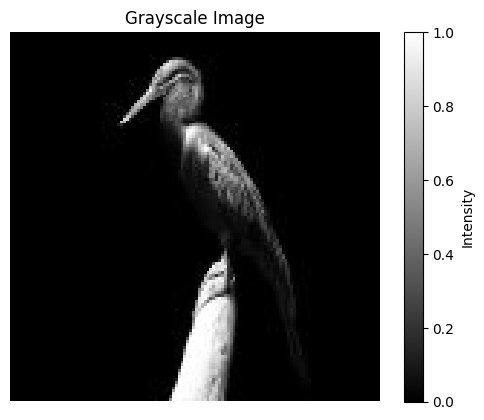

/opt/miniconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-26
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 16384 rows, 79830 columns and 144854 nonzeros
Model fingerprint: 0x74227170
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 575 rows and 33784 columns
Presolve time: 0.07s
Presolved: 15809 rows, 46046 columns, 77739 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 3.169e+04
 Factor NZ  : 4.008e+05 (roughly 30 MB of memory)
 Factor Ops : 1.953e+07 (less than 1 second per iteration)
 Threads    : 10

                  Objective                Residual
It

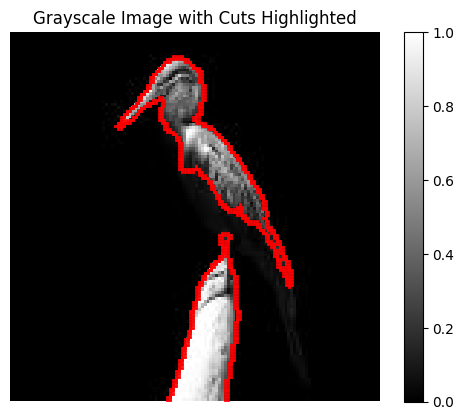

In [9]:
c()